<a href="https://colab.research.google.com/github/jbsdoki/ML_Experimenting/blob/main/LSTM_Stock_Predictor_1_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")

In [ ]:
#Create a Pandas dataframe from .csv file
msft_df = pd.read_csv("/content/sample_data/MSFT_Historical_Data.csv")
print(msft_df.shape)

(2515, 6)


In [ ]:
#Check for null entries
print(msft_df.isnull())
if msft_df.isnull().values.any():
    print("DataFrame has empty entries")
else:
    print("DataFrame does not have empty entries")

       Date  Close/Last  Volume   Open   High    Low
0     False       False   False  False  False  False
1     False       False   False  False  False  False
2     False       False   False  False  False  False
3     False       False   False  False  False  False
4     False       False   False  False  False  False
...     ...         ...     ...    ...    ...    ...
2510  False       False   False  False  False  False
2511  False       False   False  False  False  False
2512  False       False   False  False  False  False
2513  False       False   False  False  False  False
2514  False       False   False  False  False  False

[2515 rows x 6 columns]
DataFrame does not have empty entries


In [ ]:
print(msft_df.sample(10))

            Date Close/Last    Volume      Open       High        Low
1566  10/18/2018    $108.50  31794350   $110.10    $110.53    $107.83
659   05/26/2022    $265.90  25002110   $262.27    $267.11  $261.4294
2099  09/07/2016     $57.66  17484810    $57.47     $57.84    $57.405
1258  01/10/2020    $161.34  20733950  $162.824    $163.22    $161.18
147   06/11/2024    $432.68  14551100  $425.475    $432.82    $425.25
2258  01/21/2016     $50.48  40172530    $51.00     $51.58     $50.30
1515  01/03/2019     $97.40  42111650   $100.10   $100.185     $97.20
14    12/19/2024    $437.03  22963680   $441.62  $443.1834    $436.32
2073  10/13/2016     $56.92  25217590    $56.70     $57.30    $56.315
1268  12/26/2019    $158.67  14526930   $157.56    $158.73    $157.40


In [ ]:
#Display data types of dataframe
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB


In [ ]:
#Convert strings ($) and dates to usable data
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df['Close/Last'] = msft_df['Close/Last'].str.replace('$', '').astype(float)
msft_df['Open'] = msft_df['Open'].str.replace('$', '').astype(float)
msft_df['High'] = msft_df['High'].str.replace('$', '').astype(float)
msft_df['Low'] = msft_df['Low'].str.replace('$', '').astype(float)

msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
 2   Volume      2515 non-null   int64         
 3   Open        2515 non-null   float64       
 4   High        2515 non-null   float64       
 5   Low         2515 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


In [ ]:
print(msft_df.sample(5))

           Date  Close/Last    Volume    Open    High     Low
2269 2016-01-05       55.05  34059040   54.93   55.39   54.54
809  2021-10-21      310.76  16918100  307.17  311.02  306.36
1916 2017-05-31       69.84  30445790   70.53   70.74   69.81
2066 2016-10-24       61.00  54039610   59.94   61.00   59.93
1450 2019-04-08      119.93  15113170  119.81  120.02  118.64


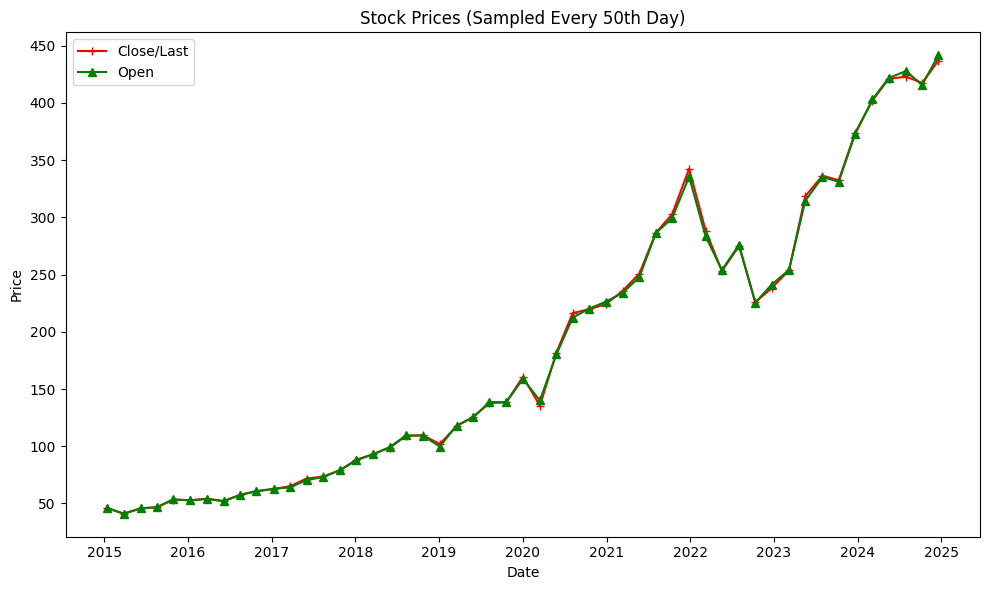

In [ ]:
#Reversing order of data so that training is at 80% (Starting from 2013)
dataframe = msft_df.iloc[::-1].reset_index(drop = True)
#Sampling every 50th row of data
sampled_data = dataframe.iloc[::50]

plt.figure(figsize=(10, 6))
plt.plot(sampled_data['Date'], sampled_data['Close/Last'], color="r", label="Close/Last", marker="+")
plt.plot(sampled_data['Date'], sampled_data['Open'], color="g", label="Open", marker="^")

plt.title("Stock Prices (Sampled Every 50th Day)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

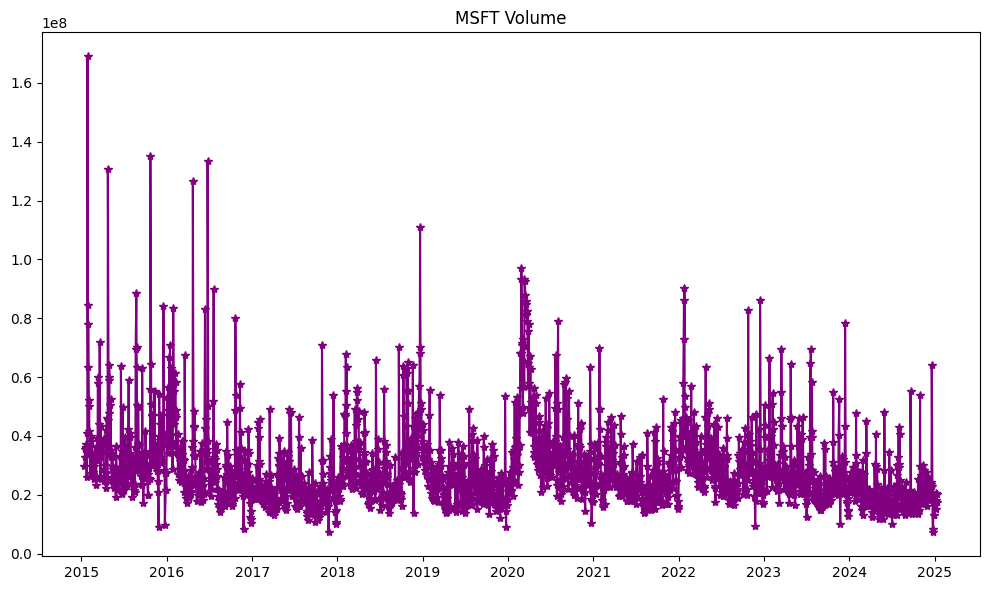

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dataframe['Date'], dataframe['Volume'], c='purple', marker='*')
plt.title("MSFT Volume")
plt.tight_layout()

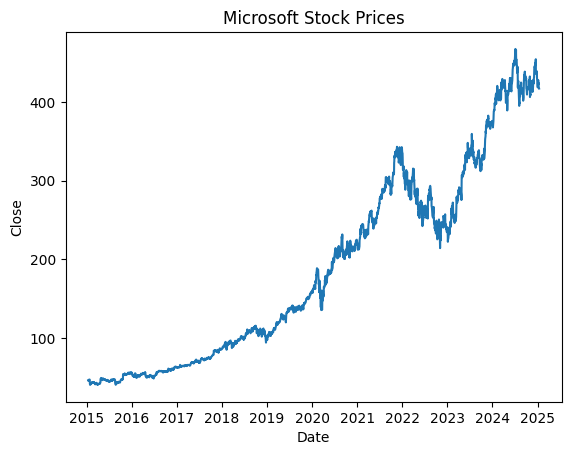

In [ ]:
plt.plot(dataframe['Date'],dataframe['Close/Last'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Microsoft Stock Prices")
plt.show()

Using more parameters to train a model can lead to unnecessary complexity and overfitting, and might include data that isn't useful. The below model repeats the previous steps but just uses 1 parameter, Close/Last, for training


In [ ]:
close_data = dataframe.filter(['Close/Last'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * 0.80))

#Scaling all parameters to between 0 and 1, large swings
#in data size can have a negative effect on the model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0]) #Use Close/Last only
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
#Use Close/Last only
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
model = keras.models.Sequential()
#Use only Close/Last parameter
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32, activation='linear'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#MSE loss function is the standard for stocks
#Huber loss function is useful when data has huge swings (strange outliers)
#adam (Adaptive Moment Estimation) dynamically adjusts learning rates
#model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0153
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0021
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012


In [ ]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = np.hstack([predictions, np.zeros((predictions.shape[0], 4))])
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:, 0]

y_test_close = y_test[:, 0]

# evaluation metrics
mse = np.mean(((predictions - y_test_close) ** 2))
print("RMSE", np.sqrt(mse))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE 19.94844327399641


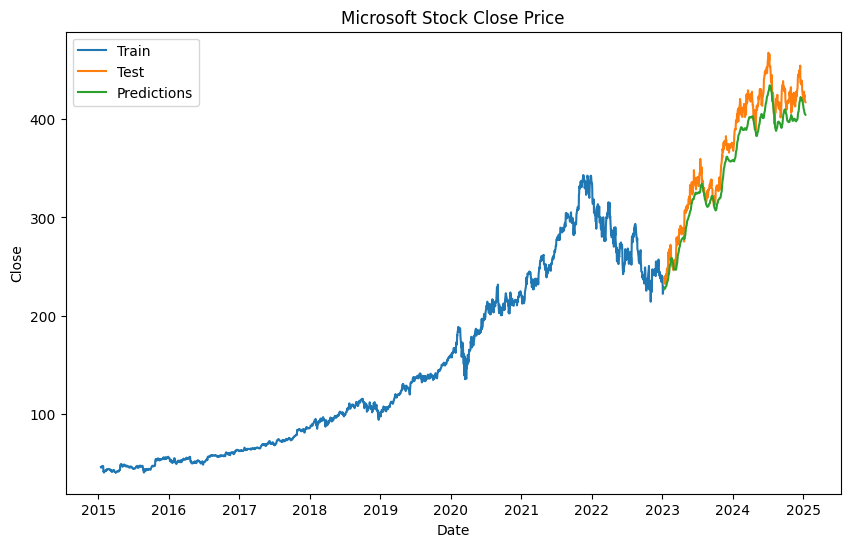

In [ ]:
train = dataframe[:training]
test = dataframe[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Close/Last'])
plt.plot(test['Date'], test[['Close/Last', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

Now I will attempt to predict the next 60 days of stock movement, whereas earlier we were feeding the model real stock prices, in this instance we will create a feedback loop that uses the models past predictions to create future predictions

In [ ]:
#Create a copy of last 60 days
future_data = scaled_data[-60:].copy()
future_predictions = []
future_dates = []

with tqdm(total=60, desc="Generating Predictions") as pbar:
  for i in range(60):
    x_future = np.array([future_data[-60:]])

    prediction = model.predict(x_future, verbose=0)
    prediction = prediction.reshape(-1, 1)

    prediction_inverse = scaler.inverse_transform(prediction)
    prediction_inverse = np.clip(prediction_inverse, a_min=0, a_max=None)

    future_predictions.append(prediction_inverse[0, 0])
    future_dates.append(dataframe['Date'].iloc[-1] + pd.DateOffset(days=i + 1))
    future_data = np.vstack([future_data[1:], scaler.transform(prediction)])

    pbar.update(1)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predictions': future_predictions})

Generating Predictions: 100%|██████████| 60/60 [00:03<00:00, 19.19it/s]


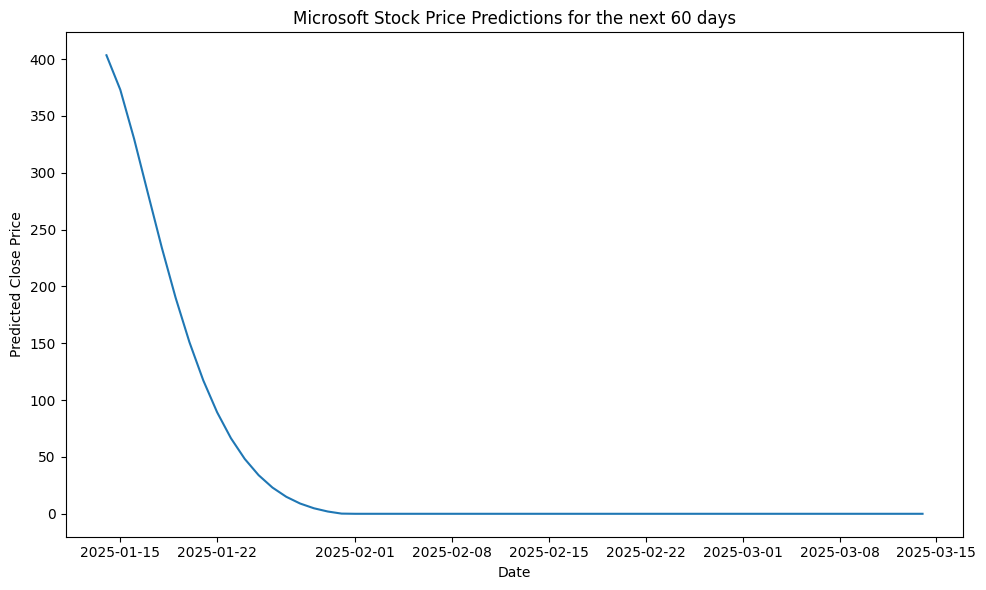

In [ ]:
# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_df['Date'], future_df['Predictions'])
plt.title('Microsoft Stock Price Predictions for the next 60 days')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.tight_layout()
plt.show()

During the first prediction we use real data to predict the next day of the Closing value of the stock, but in this section we are creating the data, small feedback errors in data predicted cause the model to predict a total collapse in value